## Geometry

Below we illustrate the 4 essential transformation groups in 2D and 3D.

In [1]:
!pip install gtsam

In [0]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Magic to work animations work in colab
from matplotlib import animation
from IPython.display import HTML

import gtsam
from gtsam import Pose2, Rot2

In [0]:
# Set plot parameters
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rc('animation', html='jshtml') # needed for animations!

The code below defines some drawing functions that works with GTSAM types.

In [75]:
import unittest
from gtsam.utils.test_case import GtsamTestCase

def affine2d_of_pose2(pose : Pose2):
  """Create a matplotlib Affine2D transform from given Pose2."""
  T = mtransforms.Affine2D()
  T.rotate(pose.theta())
  T.translate(pose.x(), pose.y())
  return T

def rect_of_pose2(worldTcenter : Pose2, width=1, height=1):
  """Create a rectangle artist at a given Pose2 `worldTcenter`."""
  centerTcorner = Pose2(-width/2, -height/2,0)
  worldTcorner = worldTcenter.compose(centerTcorner)
  rect = mpatches.Rectangle([worldTcorner.x(),worldTcorner.y()], 
                            width, height, 
                            angle = math.degrees(worldTcorner.theta()))
  return rect

def rect_of_rot2(worldRcenter : Rot2, width=1, height=1):
  """Create a rectangle artist at a given Pose2 `worldTcenter`."""
  worldTcenter = Pose2(0, 0, worldRcenter.theta())
  return rect_of_pose2(worldTcenter)

def pose2_of_rect(rect):
  """Get Pose2 from rectangle.""" 
  worldTcorner = gtsam.Pose2(rect.get_x(), rect.get_y(), math.radians(rect.angle))
  cornerTcenter = Pose2(rect.get_width()/2, rect.get_height()/2, 0)
  return worldTcorner.compose(cornerTcenter)

class TestAll(GtsamTestCase):

  def test_affine2d_of_pose2(self):
    """Test creation of Affine2D from Pose2."""
    pose = Pose2(4, 5, math.radians(30))
    T = affine2d_of_pose2(pose)
    self.assertIsInstance(T, mtransforms.Affine2D)
    np.testing.assert_array_equal(T.get_matrix(), pose.matrix())

  def test_pose2_of_rect_simple(self):
    """Test getting Pose2 of a rectangle."""
    rect = mpatches.Rectangle([0,0], 4, 5)
    pose = pose2_of_rect(rect)
    self.assertEqual(pose.x(), 2)
    self.assertEqual(pose.y(), 2.5)
    self.assertEqual(pose.theta(), rect.angle)

  def test_pose2_of_rect_rotated(self):
    """Test getting Pose2 of a rectangle."""
    theta = angle=math.radians(45)
    rect = mpatches.Rectangle([0,0], 4, 4, angle=45)
    pose = pose2_of_rect(rect)
    self.assertEqual(pose.theta(), theta)
    self.assertAlmostEqual(pose.x(), 0)
    self.assertEqual(pose.y(), math.sin(theta)*4)

  def test_rect_of_pose2_simple(self):
    """Test creation of a rectangle artist at a given Pose2."""
    pose = Pose2(4, 5, 0)
    rect = rect_of_pose2(pose, width=2, height=3)
    self.assertEqual(rect.get_width(), 2)
    self.assertEqual(rect.get_height(), 3)
    self.gtsamAssertEquals(pose2_of_rect(rect), pose)

  def test_rect_of_pose2_rotated(self):
    """Test creation of a rectangle artist at a given Pose2."""
    pose = Pose2(4, 5, math.radians(30))
    rect = rect_of_pose2(pose, width=2, height=3)
    self.gtsamAssertEquals(pose2_of_rect(rect), pose)

if __name__ == '__main__':
  unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK


The simplest of all groups is $SO(2)$, the group of rotations in the plane. In GTSAM, these are represented using `Rot2`.

In [3]:
R=Rot2(math.radians(45)); R.matrix()

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

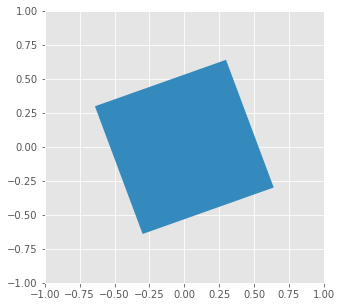

In [76]:
fig, ax = plt.subplots()
size=1
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
ax.add_artist(rect_of_rot2(Rot2(math.radians(20))))
plt.show()

In [79]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()
size=1.5
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
omega = 2*math.pi/N

# initialization function: plot the background of each frame
def init():
  rect = rect_of_pose2(pose, width=0.4, height=0.4)
  return (rect,)

# animation function. This is called sequentially  
def animate(i):
  global pose
  rect = rect_of_rot2(Rot2(i*omega), width=0.4, height=0.4)
  ax.clear()
  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  ax.add_artist(rect)

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                             frames=N,
                             interval=100, blit=False)

anim

In [80]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()
size=1.5
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
N=64
R = 1.0
pose = Pose2(R, 0, 0)
omega = 2*math.pi/N
v_x, v_y = 0, R * omega
twist = np.array([v_x, v_y, omega])

# initialization function: plot the background of each frame
def init():
  rect = rect_of_pose2(pose, width=0.4, height=0.4)
  return (rect,)

# animation function. This is called sequentially  
def animate(i):
  global pose
  rect = rect_of_pose2(pose, width=0.4, height=0.4)
  pose = pose.compose(Pose2.Expmap(twist))
  ax.clear()
  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  ax.add_artist(rect)

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                             frames=N,
                             interval=100, blit=False)

anim

In [0]:
anim.save('test.mpg')